In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import torch
import torch.nn as nn
from scipy.optimize import curve_fit
import os
import copy
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
filename = '../data/ple_chirality/BachiloAssign.dat'

# カイラリティとPLEピークデータの読み込み

In [3]:
chiraldata = []
with open(filename, 'r') as f:
    match_pattern = r'^\s*(#.*|)$'
    line = f.readline()
    while line:
        match = re.match(match_pattern, line)
        if not match:
            chiraldata.append([float(x) for x in line.split()])

            # Convert the first two columns to integers
            chiraldata[-1][0] = int(chiraldata[-1][0])
            chiraldata[-1][1] = int(chiraldata[-1][1])
            ###########################################

            # add wavelength column
            chiraldata[-1].append(1240/chiraldata[-1][3])
            chiraldata[-1].append(1240/chiraldata[-1][4])
        line = f.readline()

print(chiraldata)

[[5, 4, 0.62, 1.488, 2.567, 26.32950349, 1.725134409, 833.3333333333334, 483.0541488118426], [6, 4, 0.69, 1.42, 2.134, 23.41322445, 1.502816901, 873.2394366197184, 581.0684161199625], [9, 1, 0.76, 1.359, 1.789, 5.208719103, 1.316409124, 912.4356144223694, 693.1246506428173], [8, 3, 0.78, 1.302, 1.87, 15.2953443, 1.43625192, 952.3809523809523, 663.1016042780748], [6, 5, 0.76, 1.272, 2.187, 26.9955084, 1.719339623, 974.8427672955975, 566.9867398262461], [7, 5, 0.83, 1.212, 1.925, 24.50363346, 1.588283828, 1023.1023102310231, 644.1558441558442], [10, 2, 0.88, 1.177, 1.689, 8.948275565, 1.435004248, 1053.5259133389975, 734.1622261693309], [9, 4, 0.92, 1.126, 1.722, 17.4801702, 1.529307282, 1101.2433392539965, 720.0929152148665], [8, 4, 0.84, 1.114, 2.112, 19.10660535, 1.895870736, 1113.1059245960503, 587.1212121212121], [7, 6, 0.89, 1.105, 1.916, 27.4570761, 1.733936652, 1122.1719457013576, 647.1816283924844], [9, 2, 0.81, 1.088, 2.25, 9.826429816, 2.068014706, 1139.705882352941, 551.11111

chiaraldata\
0 - n\
1 - m\
2 - dt\
3 - E11\
4 - E22\
5 - theta\
6 - E22/E11\
7 - PLwavelength\
8 - ExciteWavelength\

# 実際に取れたPLデータの読み込み

In [4]:
data_dir  = '../data/pldata'

In [5]:
rawdatadict = {}
for filename in os.listdir(data_dir):
    exictelength = filename.split('_')[0]
    rawdatadict[exictelength] = []
    with open(os.path.join(data_dir, filename), 'r') as f:
        match_pattern = r'^\s*(#.*|)$'
        line = f.readline()
        while line:
            match = re.match(match_pattern, line)
            if not match:
                rawdatadict[exictelength].append([float(x) for x in line.split(',')])
            line = f.readline()
print(rawdatadict)


{'650': [[941.7710775862068, 5.0], [942.760172413793, 43.0], [943.7492672413794, -26.0], [944.7383620689656, 9.0], [945.7274568965516, -4.0], [946.7165517241378, 315.0], [947.705646551724, 718.0], [948.6947413793101, 789.0], [949.6838362068963, 1289.0], [950.6729310344826, 2234.0], [951.6620258620688, 2751.0], [952.6511206896552, 3009.0], [953.6402155172414, 3346.0], [954.6293103448277, 3793.0], [955.6184051724139, 4087.0], [956.6074999999998, 4207.0], [957.5965948275862, 4224.0], [958.5856896551724, 4243.0], [959.5747844827586, 4256.0], [960.5638793103446, 4265.0], [961.552974137931, 4212.0], [962.5420689655172, 4128.0], [963.5311637931034, 3986.0], [964.5202586206896, 3781.0], [965.5093534482758, 3599.0], [966.4984482758621, 3403.0], [967.487543103448, 3251.0], [968.4766379310344, 3126.0], [969.4657327586206, 2936.0], [970.4548275862069, 2811.0], [971.4439224137931, 2651.0], [972.4330172413793, 2576.0], [973.4221120689656, 2462.0], [974.4112068965518, 2487.0], [975.4003017241379, 247

In [6]:
myxticks = []
myyticks = [int(key) for key in rawdatadict.keys()]
myyticks = myyticks[::-1]

for slice in rawdatadict.values():
    for x in slice:
        myxticks.append(int(x[0]))
    break
print(myxticks)
print(myyticks)

[941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 11

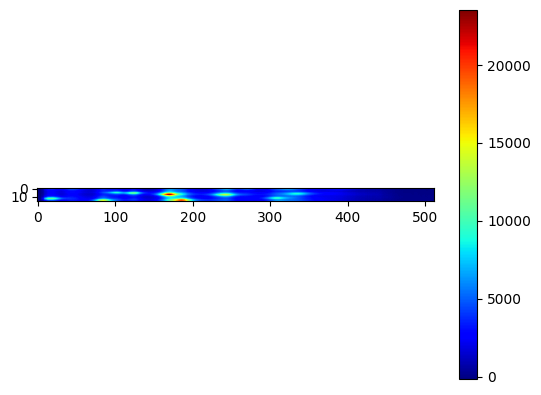

In [7]:
d1_data = []
for key in rawdatadict:
    temp = []
    for data in rawdatadict[key]:
        temp.append(data[1])
    d1_data.append(temp)
d1_datal = d1_data[::-1]#PLEマップの原点は左下．画像の原点は左上．
d1_data = torch.tensor(d1_datal)
plt.imshow(d1_data, cmap='jet')
plt.colorbar()
plt.show()



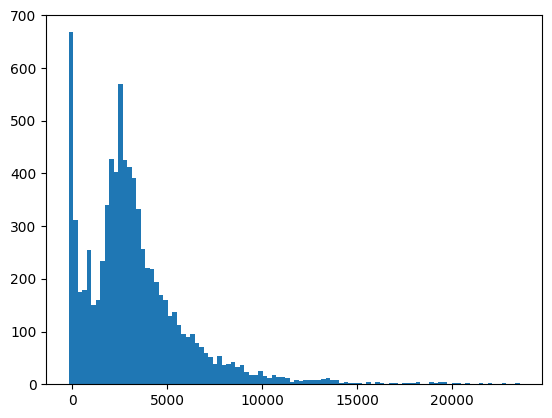

In [8]:
flatten_d1data = d1_data.flatten()
plt.hist(flatten_d1data, bins=100)
plt.show()

In [9]:
def plot10x(data: torch.Tensor) -> None:
    pltdata = []
    for d in data:
        for _ in range(10):
            pltdata.append(d)
    plt.imshow(pltdata, cmap='jet')
    plt.colorbar()
    plt.show()

torch.Size([160, 512])


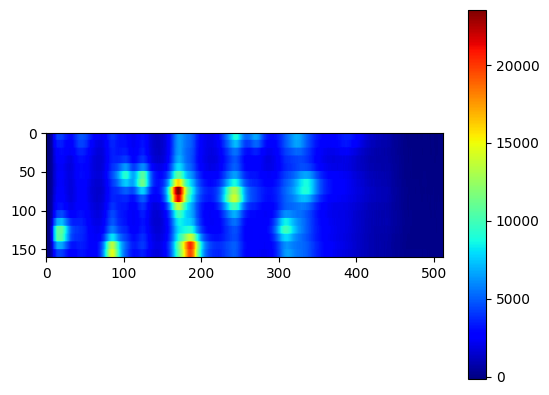

In [10]:
d2_data = []
for d1slice in d1_datal:
    for _ in range(10):
        d2_data.append(d1slice)

d2_data = torch.tensor(d2_data)
print(d2_data.shape)
plot10x(d1_data)

# プーリング層による平滑化

In [11]:
class poolingfilter(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.pool1 = nn.MaxPool2d(kernel_size=(3,31), stride=1, padding=(1,15))

    def forward(self, x):
        x = self.pool1(x)
        return x

In [12]:
poolfilter = poolingfilter()

torch.Size([1, 1, 16, 512])


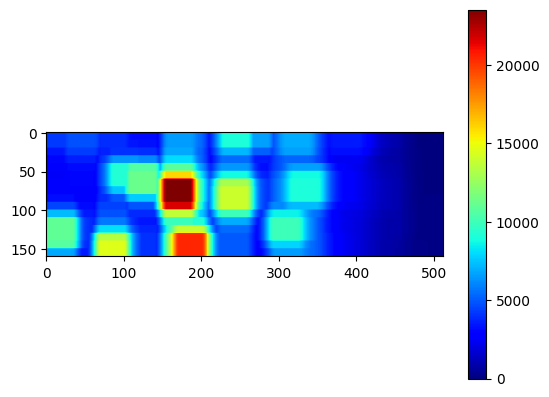

In [13]:
d1_datafiltered = poolfilter(d1_data.unsqueeze(0).unsqueeze(0))
print(d1_datafiltered.shape)
plot10x(d1_datafiltered.squeeze(0).squeeze(0))

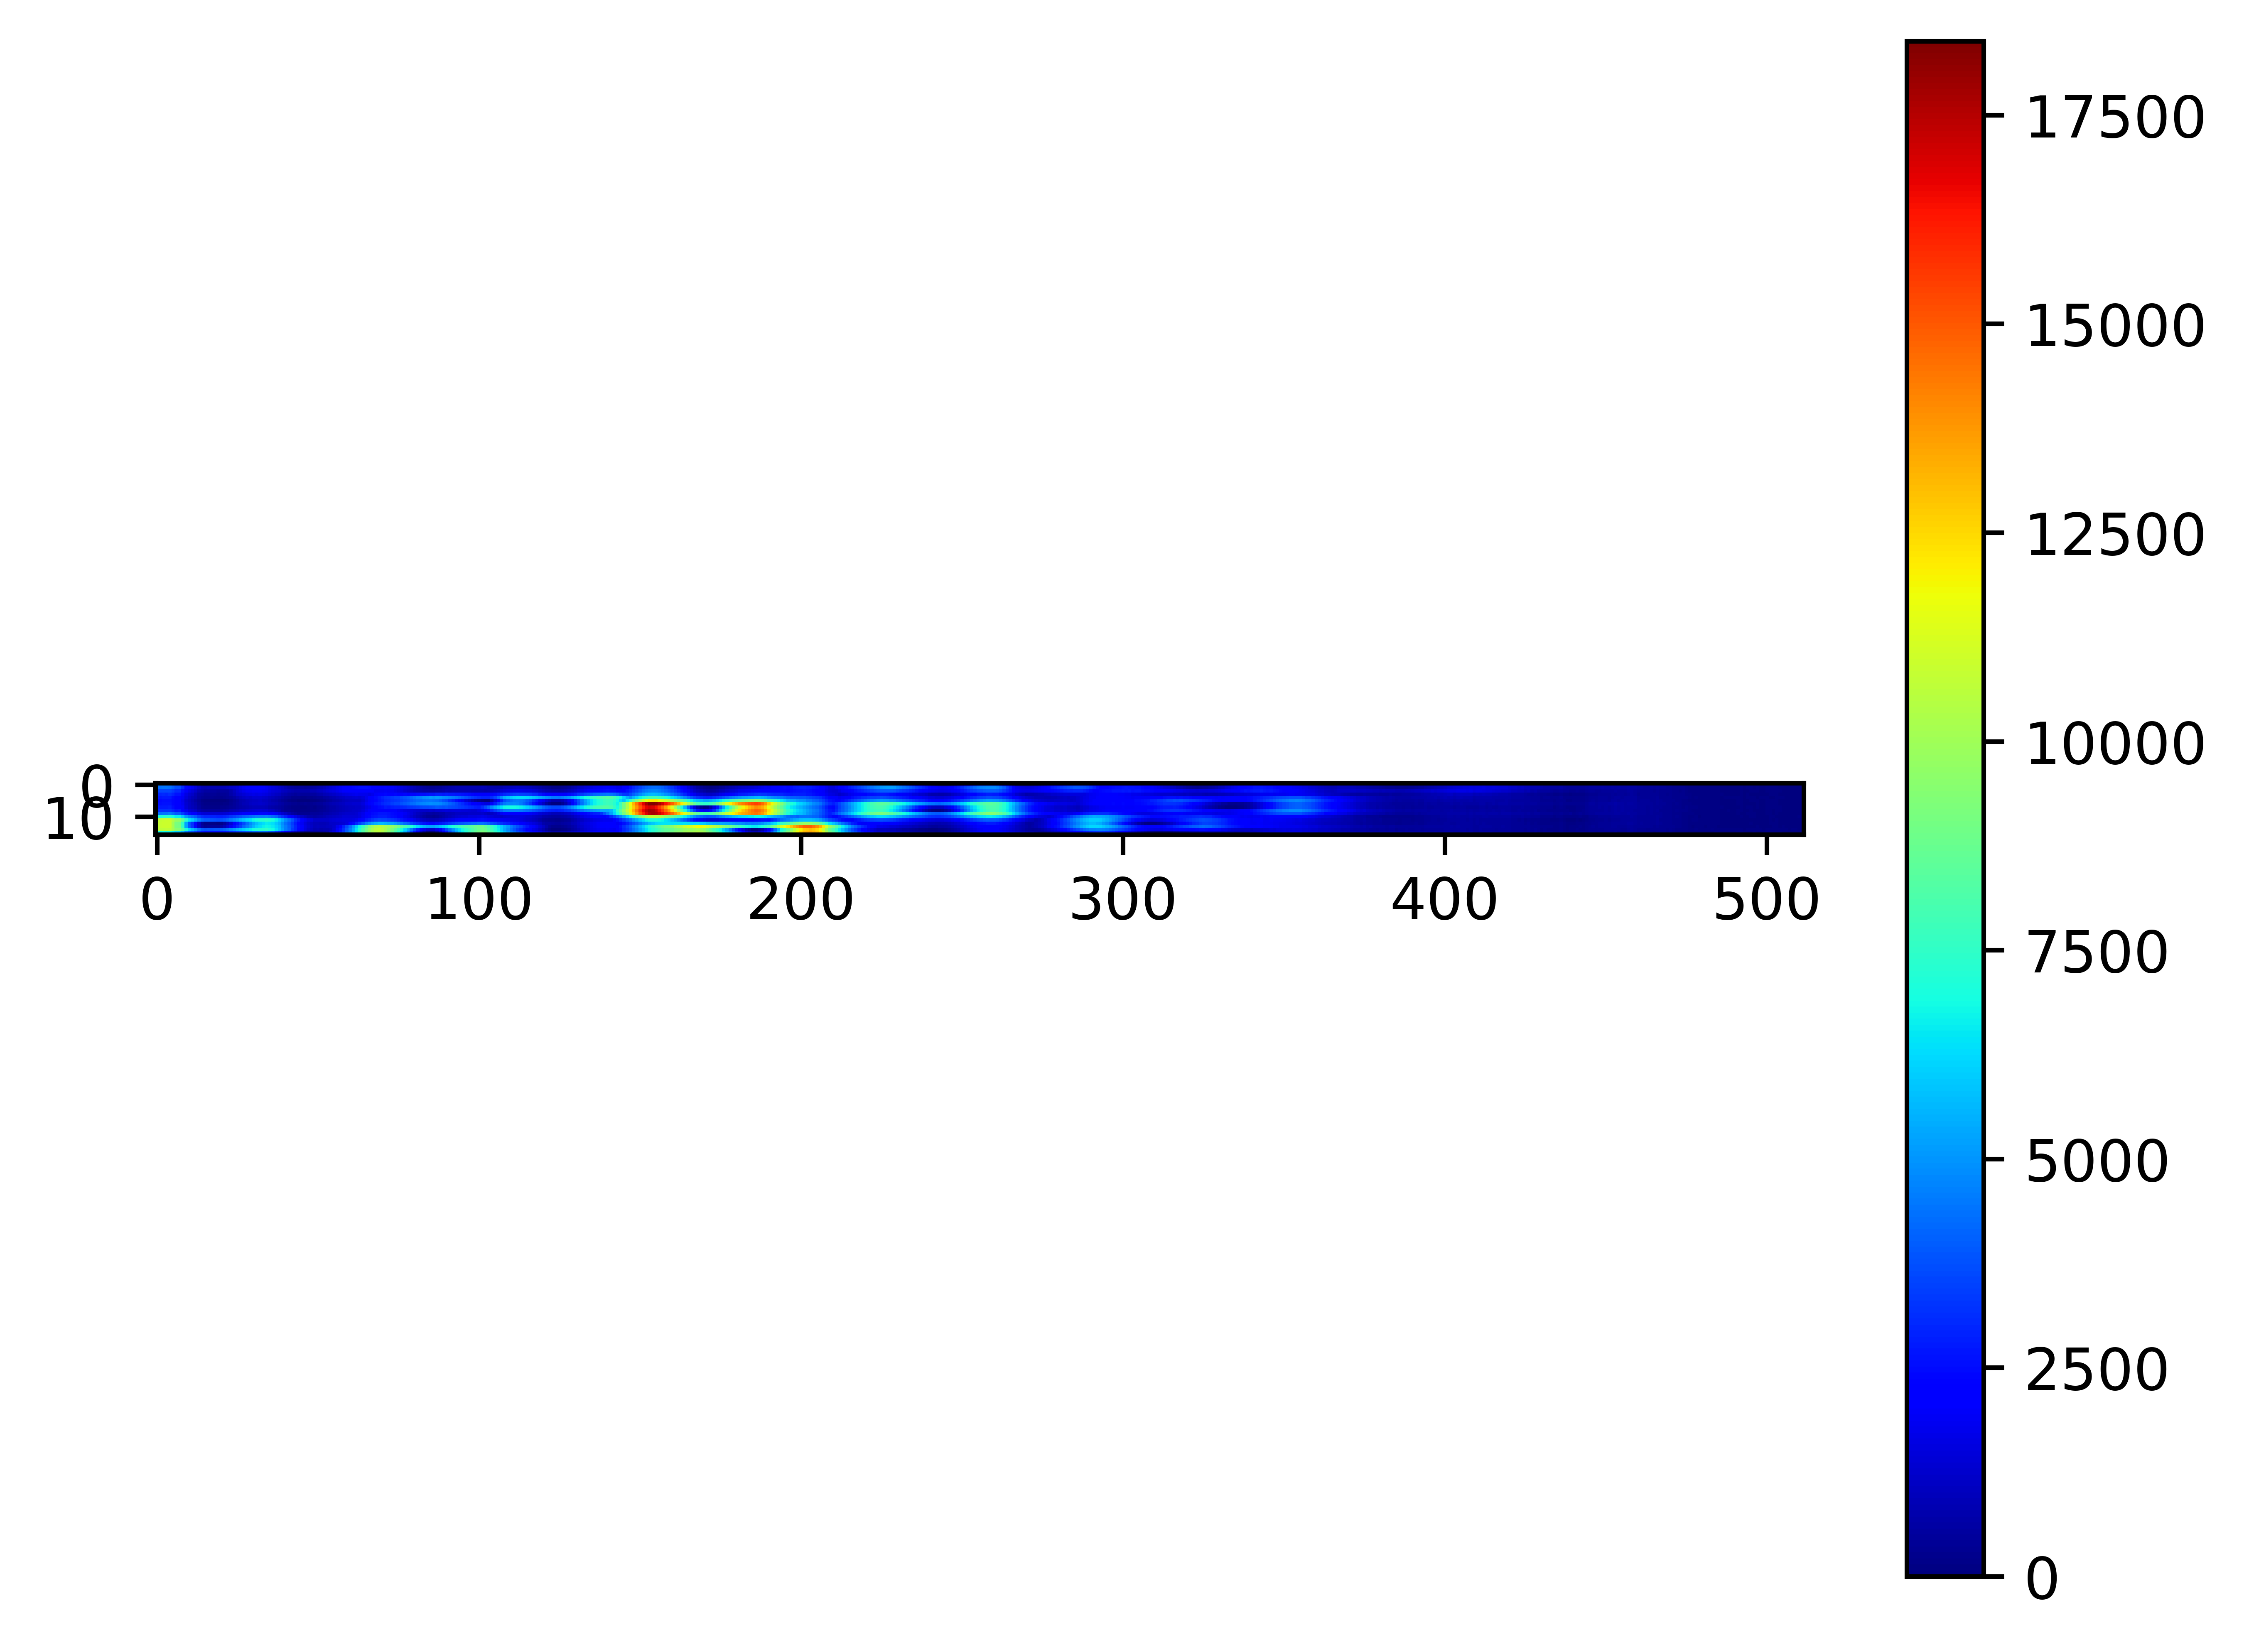

In [14]:
minused = d1_datafiltered - d1_data
plt.figure(dpi=1000)
plt.imshow(minused.squeeze(0).squeeze(0).detach().numpy(), cmap='jet')
plt.colorbar()
plt.show()

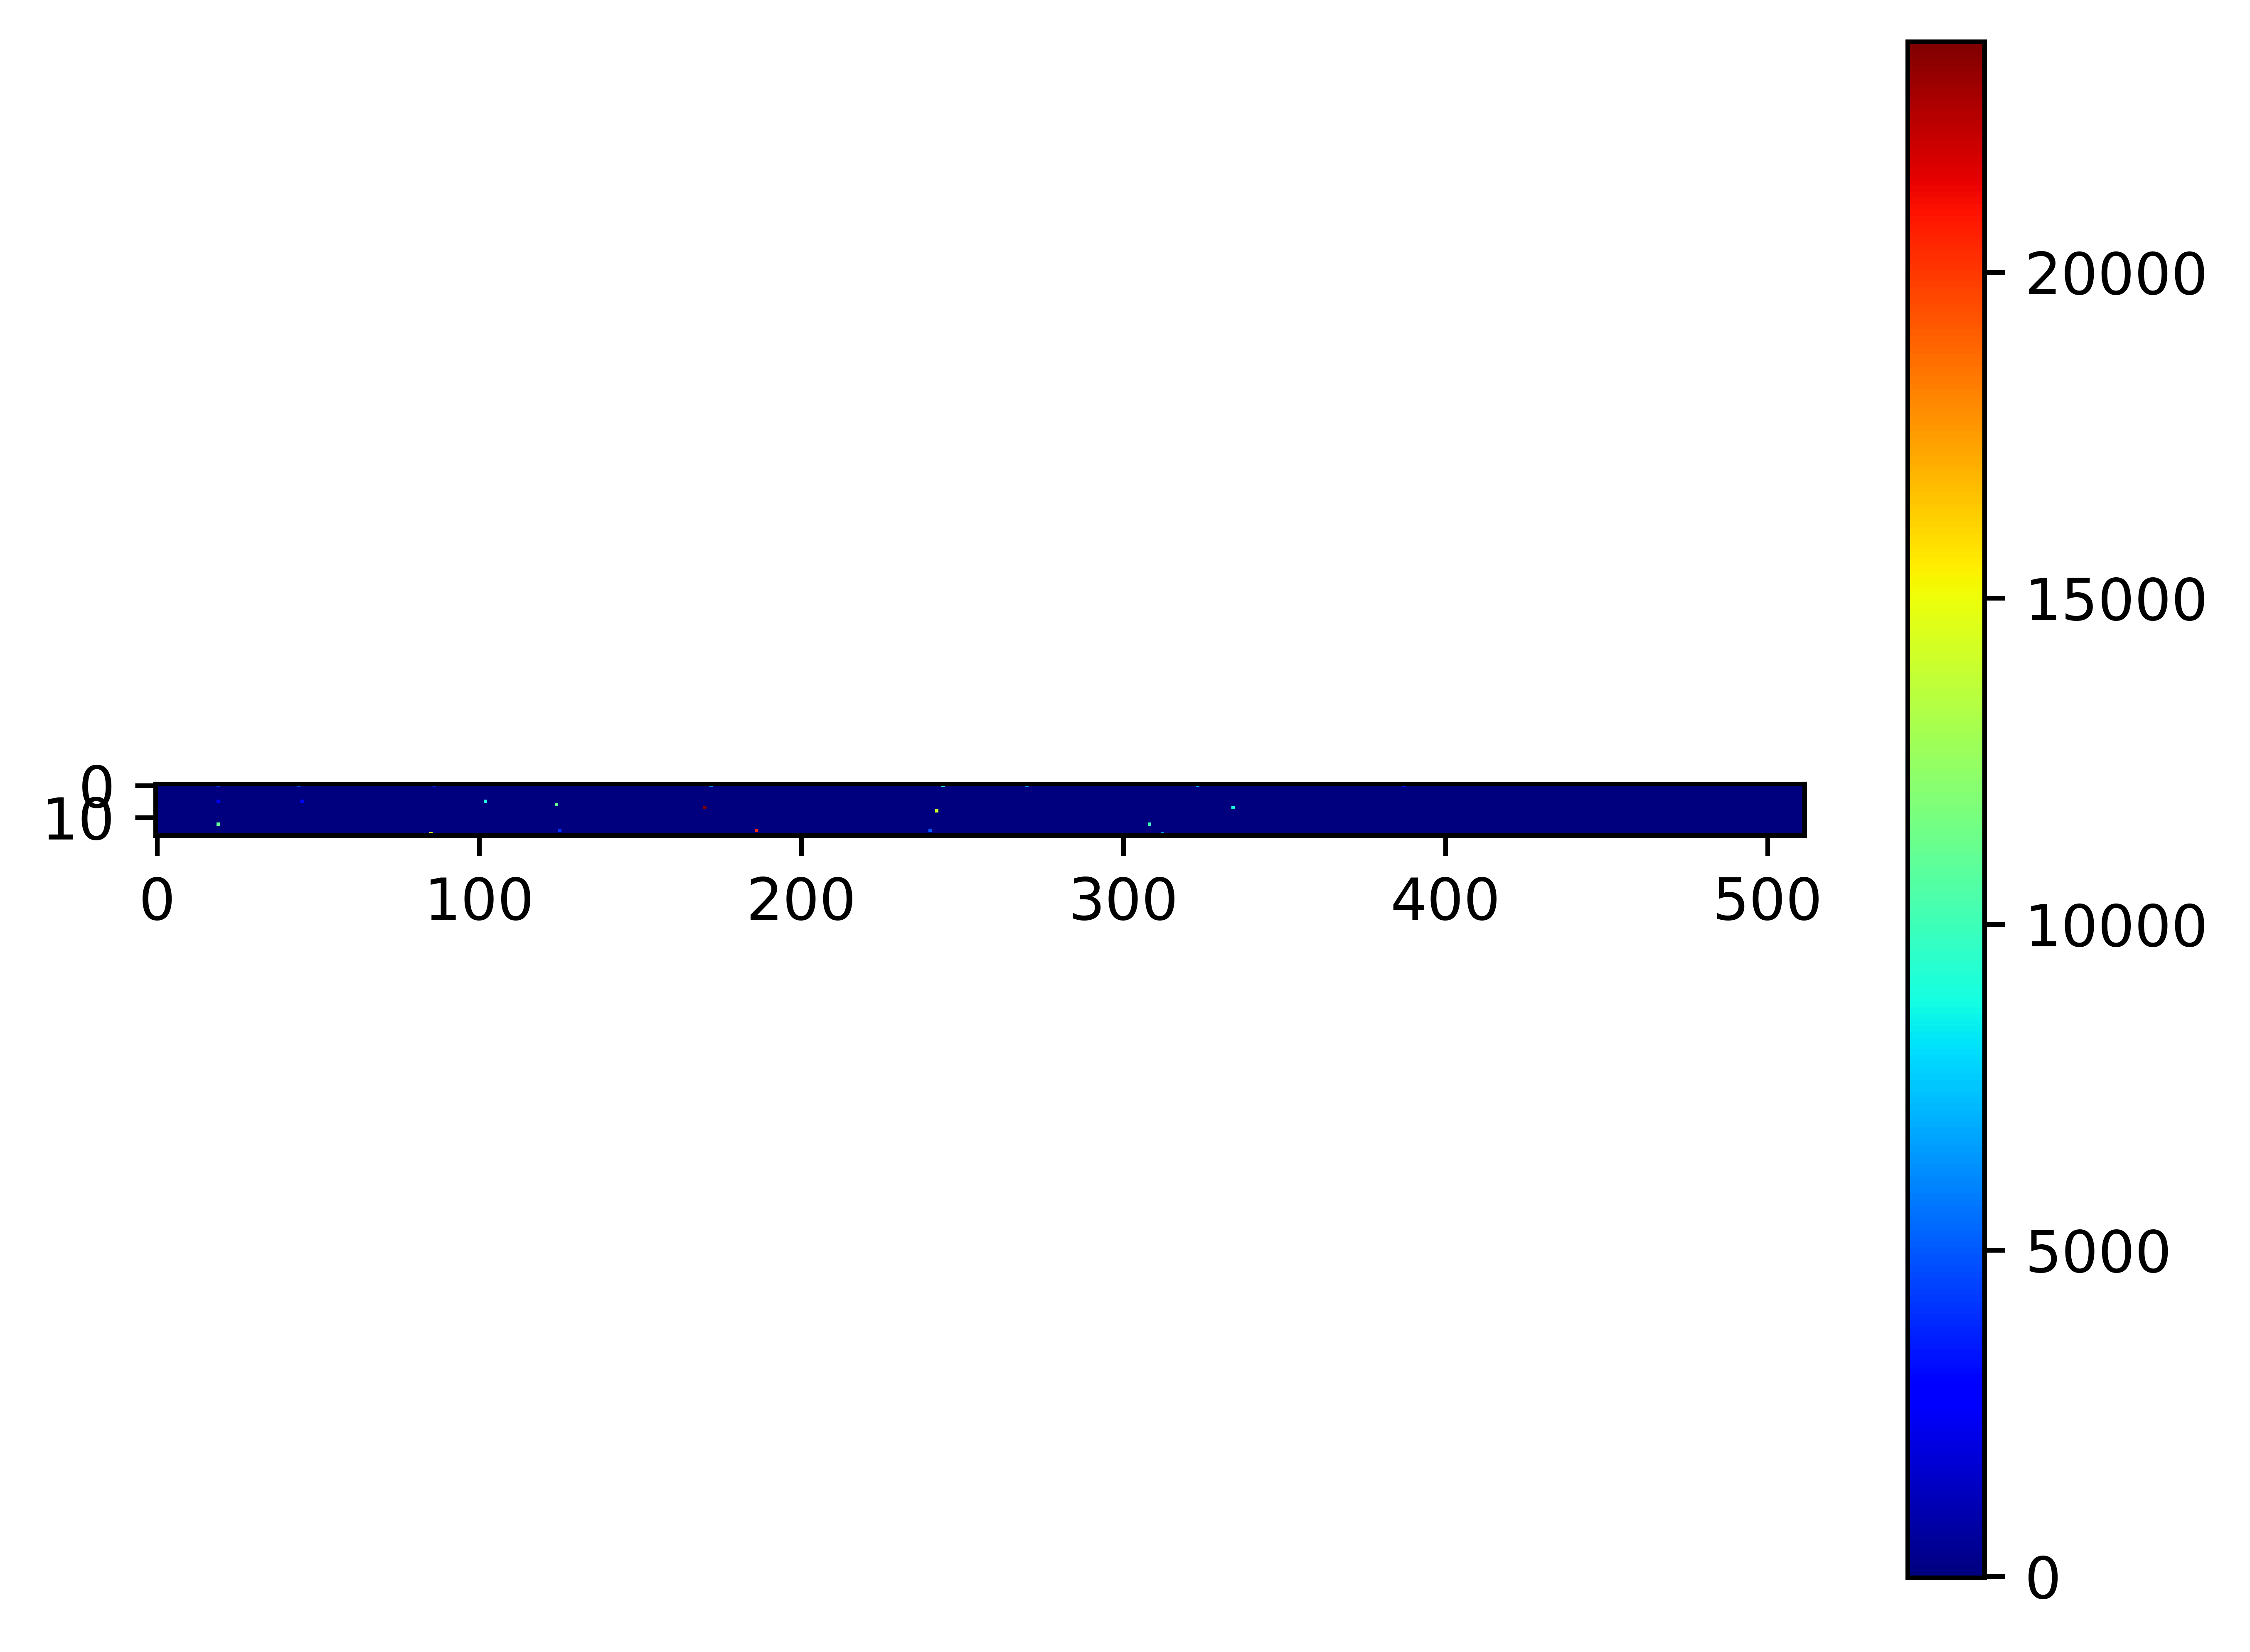

In [15]:
plt.figure(dpi=1000)
equal = torch.where(minused == 0.0, d1_data, 0.0)
plt.imshow(equal.squeeze(0).squeeze(0).detach().numpy(), cmap='jet')
plt.colorbar()
plt.show()

In [16]:
threshold = 7000

In [17]:
index = torch.where(equal > threshold)

In [18]:
indexcopy = copy.deepcopy(index)
index = []
for slice in indexcopy:
    slice = slice.tolist()
    index.append(slice)

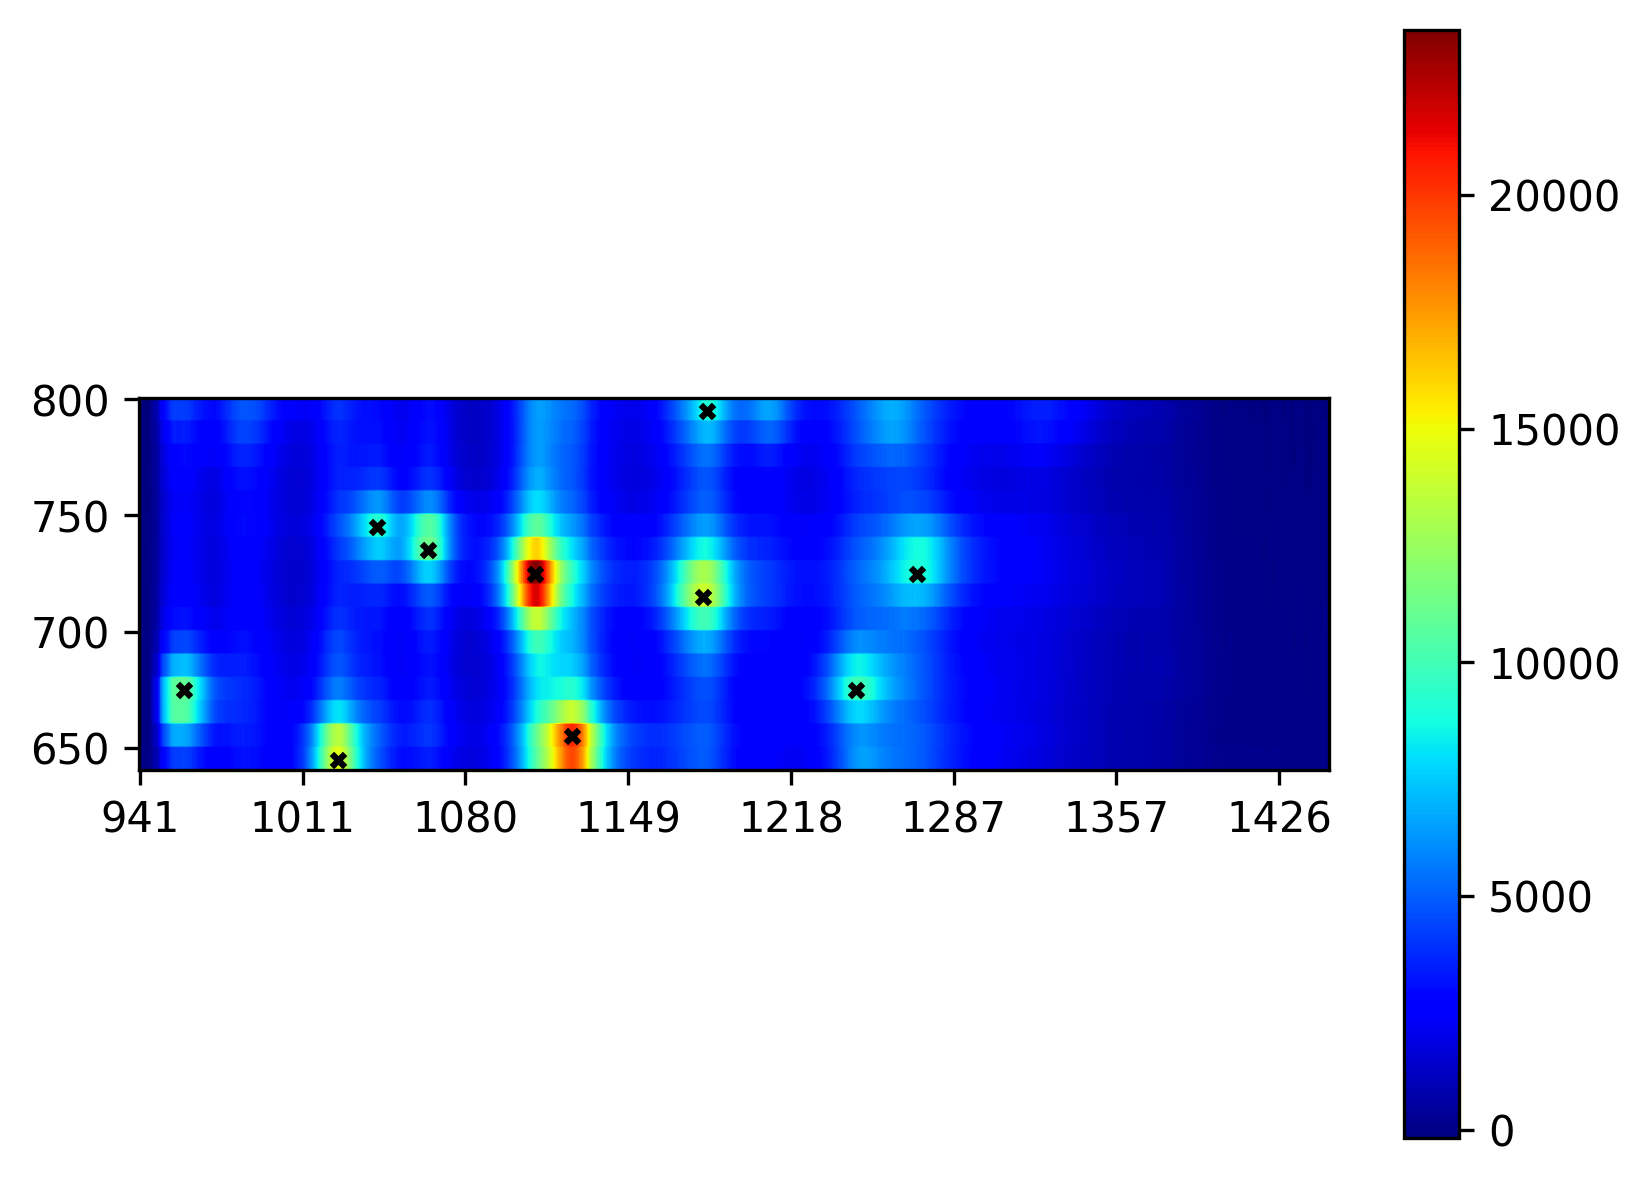

In [19]:
pltdata = []
for d in d1_data:
    for _ in range(10):
        pltdata.append(d)

plt.figure(dpi=300)
plt.imshow(pltdata, cmap='jet')
plt.colorbar()

for i in range(len(index[0])):
    plt.scatter(index[3][i], index[2][i]*10+5, c='black', s=10, marker='x', label='found_peaks')
imgxtick=[i for i in range(len(pltdata[0]))]
plt.xticks(imgxtick[::70], myxticks[::70])
imgytick=[i for i in range(len(pltdata))]
imgytick = imgytick[::10]
plt.yticks(imgytick[::5], myyticks[::5])
plt.show()

In [20]:
def func(x, a, b):
    return a*x + b

In [21]:
popt_x, _ = curve_fit(func, imgxtick, myxticks)
popt_y, _ = curve_fit(func, imgytick, myyticks)

In [22]:
for i in range(len(index[0])):
    peakx = func(index[3][i], *popt_x)
    peaky = func(index[2][i]*10+5, *popt_y)
    print(f'Peak at ({peakx}, {peaky})')

Peak at (1182.6115511759274, 795.0)
Peak at (1042.1577836056067, 745.0)
Peak at (1063.9182264686142, 735.0)
Peak at (1109.4173342730842, 725.0)
Peak at (1271.6315447064126, 725.0)
Peak at (1180.6333290974721, 715.0)
Peak at (960.0615673497151, 675.0)
Peak at (1245.9146576864946, 675.0)
Peak at (1125.2431109007262, 655.0)
Peak at (1025.3428959387375, 645.0)


In [23]:
fitdata = []
for i in range(len(index[0])):
    peakx = func(index[3][i], *popt_x)
    peaky = func(index[2][i]*10+5, *popt_y)

    nearestdistance = 10000000000
    nearestindex = None
    for j in range(len(chiraldata)):
        distance = np.sqrt((peakx - chiraldata[j][7])**2 + (peaky - chiraldata[j][8])**2)
        if distance < nearestdistance:
            nearestdistance = distance
            nearestindex = j
    
    fitdata.append([peakx, peaky, chiraldata[nearestindex][0], chiraldata[nearestindex][1], chiraldata[nearestindex][7], chiraldata[nearestindex][8]])
fitdata = np.array(fitdata)

fitdata\
0 - foundpeakX\
1 - foundpeakY\
2 - NearestSWCNT_N\
3 - NearestSWCNT_M\
4 - NearestSWCNT_X\
5 - NearestSWCNT_Y\

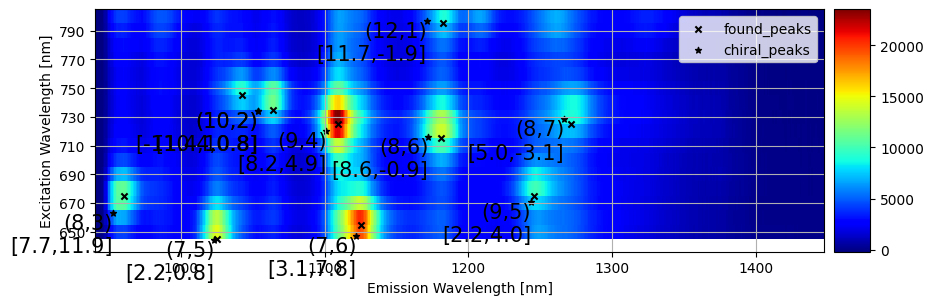

In [26]:
x = np.array(myxticks)
y = np.array(myyticks)
yticks = np.arange(650, 800 + 10, 10*2)
X, Y = np.meshgrid(x, y)
Z = np.array(d1_datal)

# グラフ描画
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, aspect='equal')
contour = ax.pcolormesh(X, Y, Z, cmap='jet', shading='auto', norm=Normalize(vmin=Z.min(), vmax=Z.max()))

# カラーバー調整用
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
pp = fig.colorbar(contour, cax=cax, orientation='vertical')

ax.set_yticks(yticks)
ax.set_xlabel('Emission Wavelength [nm]')
ax.set_ylabel('Excitation Wavelength [nm]')
ax.grid()

ax.scatter(fitdata[:,0], fitdata[:,1], c='black', s=20, marker='x', label='found_peaks')
ax.scatter(fitdata[:,4], fitdata[:,5], c='black', s=20, marker='*', label='chiral_peaks')
for ifitdata in fitdata:
    ax.text(ifitdata[4], ifitdata[5], f'({int(ifitdata[2])},{int(ifitdata[3])})\n[{ifitdata[0]-ifitdata[4]:.1f},{ifitdata[1]-ifitdata[5]:.1f}]', fontsize=15, ha='right', va='top')

ax.legend()

plt.show()